<a href="https://colab.research.google.com/github/Rish-5k/RishRepository/blob/main/Thesis_CustomerPersonalityAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!pip install dataprep
from dataprep.eda import plot, plot_correlation, create_report, plot_missing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 19.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.0/764.0 kB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 99.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [3]:
df = pd.read_csv("/content/marketing_campaign.csv", sep='\t')
df.head()

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

In [4]:
sales_channel = df[['NumStorePurchases','NumWebPurchases','NumCatalogPurchases']]
sales_channel = pd.melt(sales_channel, value_vars=['NumStorePurchases','NumWebPurchases','NumCatalogPurchases'],
                        var_name='Channel',value_name='No_Transactions'
                        )

In [5]:
channel_grp = sales_channel.groupby('Channel')
sc_df = channel_grp[['No_Transactions']].sum()
sc_df

No_Transactions
Channel                             
NumCatalogPurchases             5963
NumStorePurchases              12970
NumWebPurchases                 9150

# **Exploratory Data Analysis**



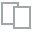
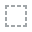
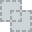
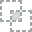
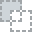
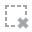
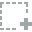
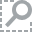
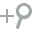
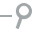
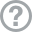
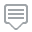
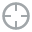
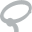
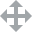
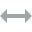
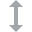
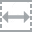
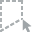
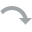
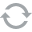
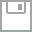
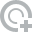
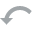
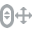
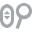
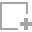
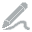
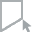
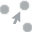
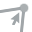
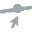

In [6]:
plot(df)

From these graphs, we observe some inaccuracies - the starting range for the Year_Birth feature is 1890. It is amusing to think people would be shopping online in that era! That being said, this data requires some cleaning, and some redefinition of scales, as in, the Income feature seems to have too many values of negligible frequency. From the insights gained above, we see that the Income feature has some NULL values, which we will replace with the median value for better results.

In [7]:
clean_df = df.drop(df[(df['Year_Birth'] < 1935) |
                      (df['Income'] > 175000)].index)
clean_df['Income'].fillna(clean_df['Income'].median(), inplace=True)


It would be beneficial to have information about the total expenditure of each customer, which can be determined by summing up the individual amounts spent on various items such as wines, fruits, meat products, and so on. Additionally, knowing the number of purchases made by each customer would also provide valuable insights.


In [8]:
clean_df['Total_Expenditure'] = clean_df.filter(like='Mnt').sum(axis=1)
clean_df['Total_Purchases'] = clean_df.filter(regex='Num[^Deals].+Purchases').sum(axis=1)

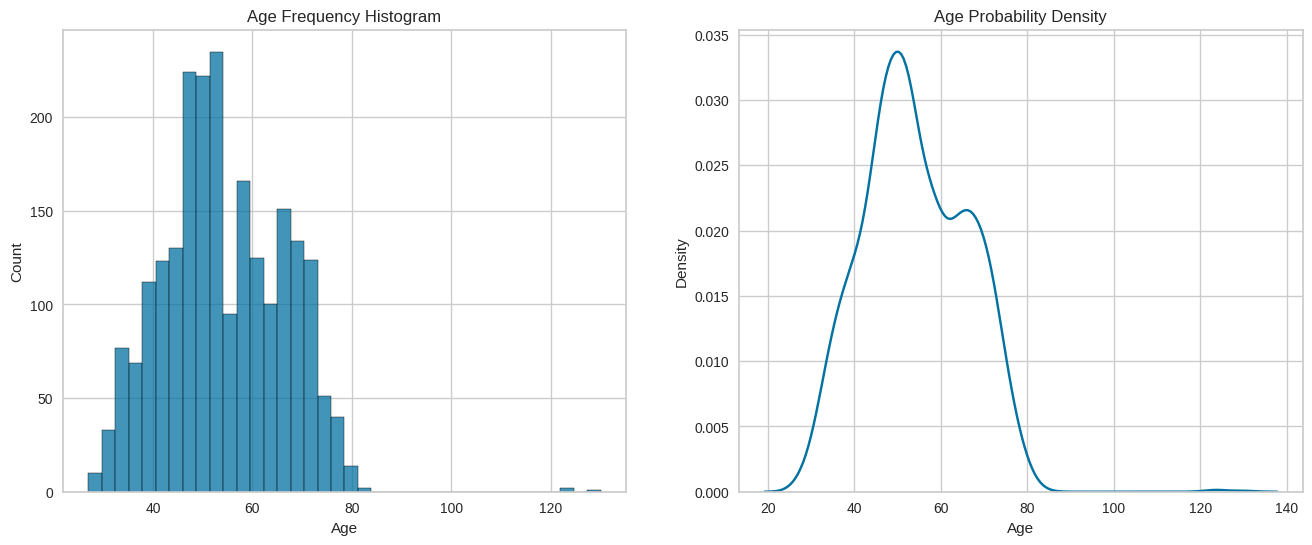

In [9]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
currentYear = datetime.datetime.now()
df['Age'] = currentYear.year - df['Year_Birth']
sns.histplot(df['Age'], ax=axes[0]).set(title='Age Frequency Histogram')
sns.kdeplot(df['Age'], ax=axes[1]).set(title='Age Probability Density')
fig.show()

<ipython-input-10-36ddd1c53086>:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  income_vs_age = sns.lineplot(x="Age", y="Income", data=df, ci=None)


<Axes: title={'center': 'Income vs Age'}, xlabel='Age', ylabel='Income'>

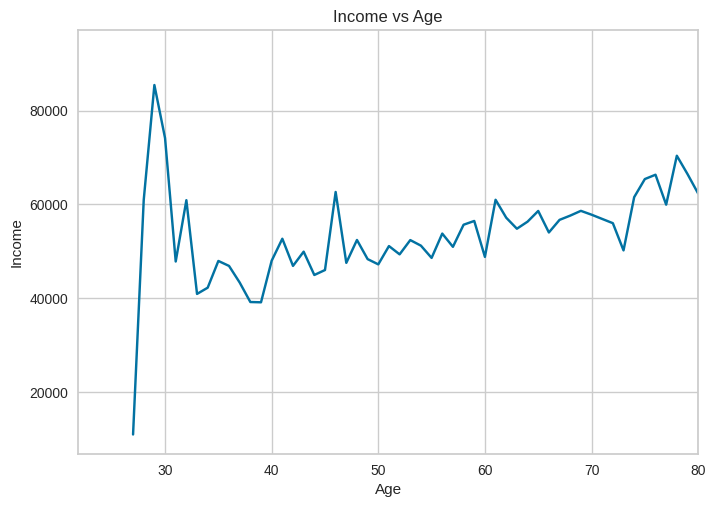

In [10]:
income_vs_age = sns.lineplot(x="Age", y="Income", data=df, ci=None)
income_vs_age.set(xlim=(None, 80), title='Income vs Age')
income_vs_age

<Axes: title={'center': 'Income vs Expenditure on Wine based on Education'}, xlabel='Income', ylabel='MntWines'>

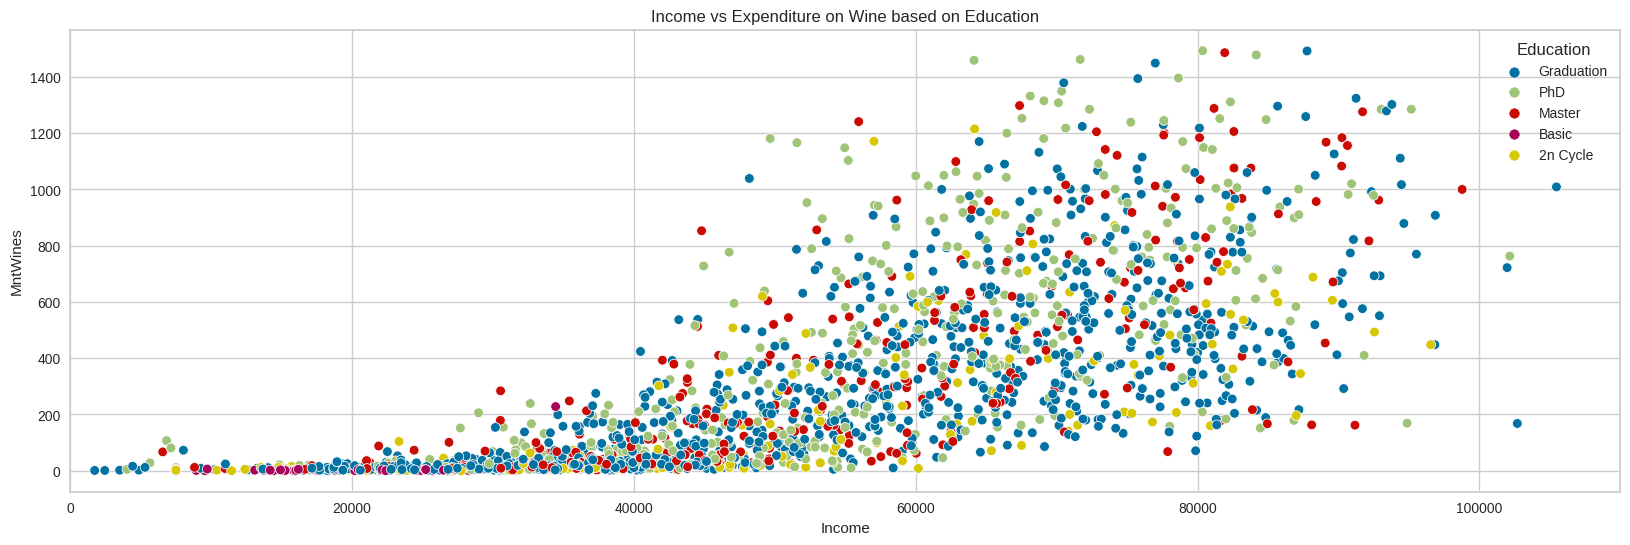

In [11]:
plt.figure(figsize=(20,6))
edu_vs_wine = sns.scatterplot(x="Income", y="MntWines", data=df, hue="Education")
edu_vs_wine.set(xlim=(0, 110000), title="Income vs Expenditure on Wine based on Education")
edu_vs_wine

<Axes: title={'center': 'Income vs Expenditure on Wine based on Kids at Home'}, xlabel='Income', ylabel='MntWines'>

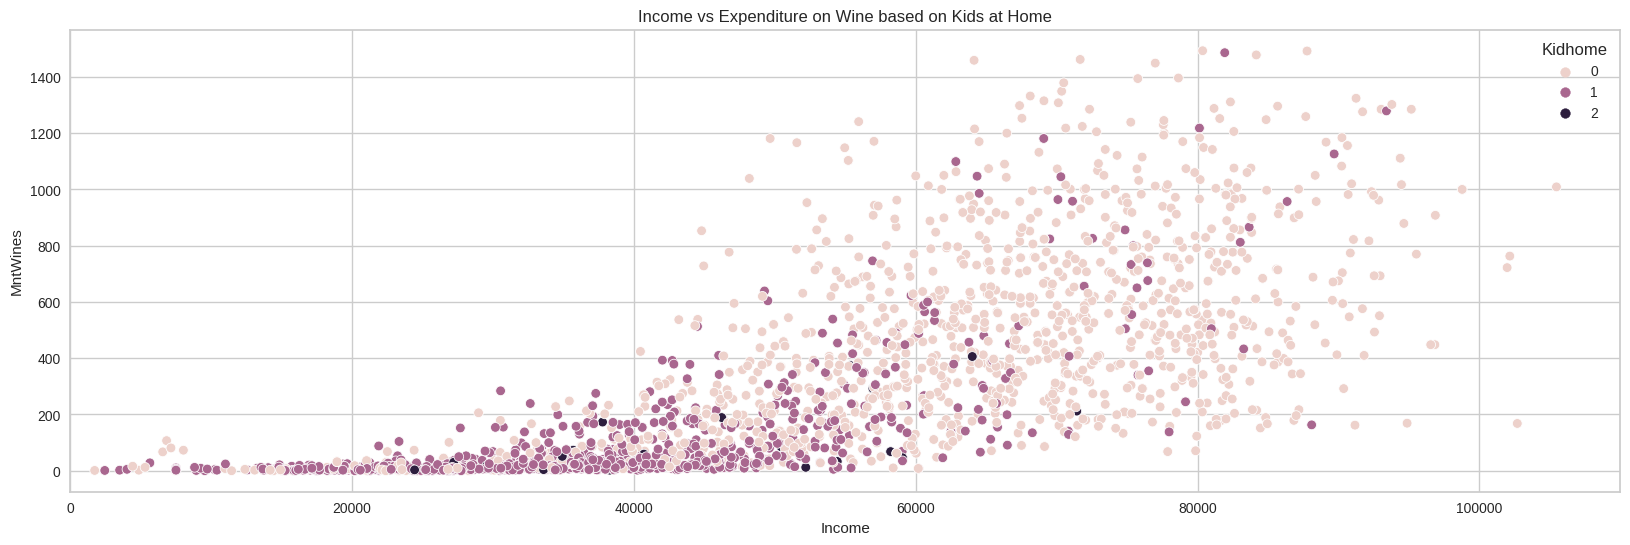

In [12]:
plt.figure(figsize=(20,6))
edu_vs_wine_kidhome = sns.scatterplot(x="Income", y="MntWines", data=df, hue="Kidhome")
edu_vs_wine_kidhome.set(xlim=(0, 110000), title="Income vs Expenditure on Wine based on Kids at Home")
edu_vs_wine_kidhome

<Axes: title={'center': 'Income vs Expenditure on Wine based on Teens at Home'}, xlabel='Income', ylabel='MntWines'>

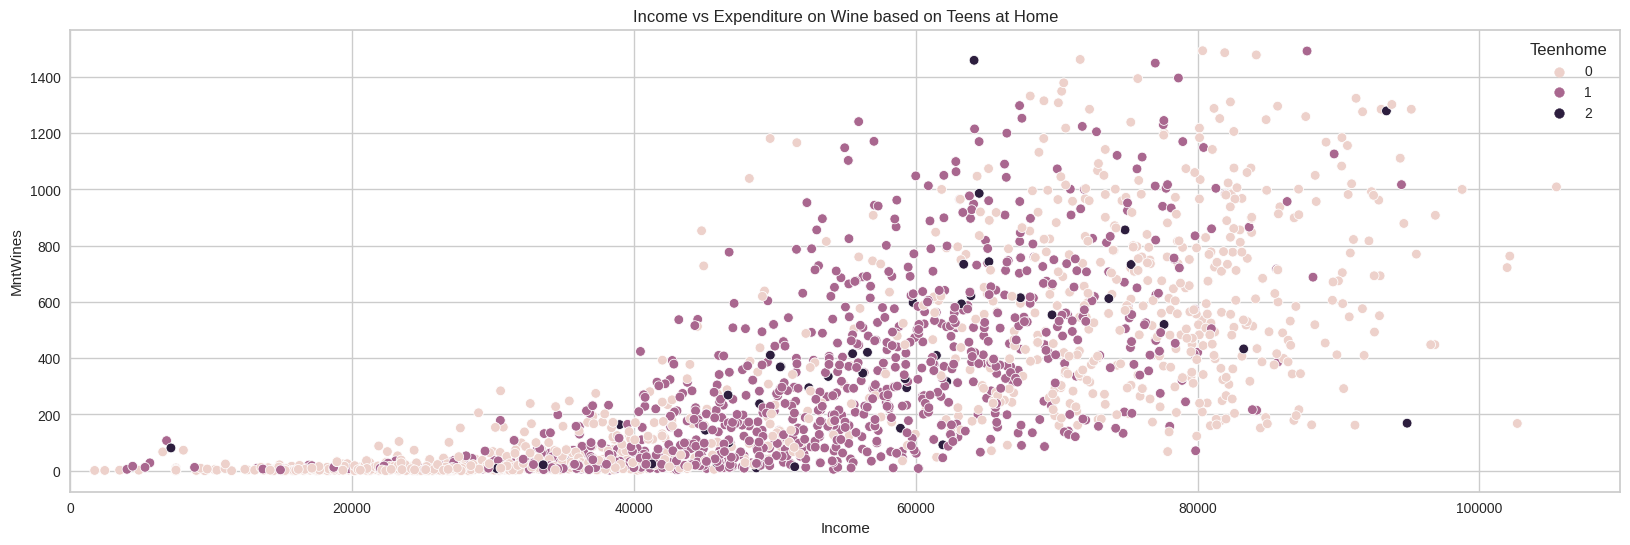

In [13]:
plt.figure(figsize=(20,6))
edu_vs_wine_teenhome = sns.scatterplot(x="Income", y="MntWines", data=df, hue="Teenhome")
edu_vs_wine_teenhome.set(xlim=(0, 110000), title="Income vs Expenditure on Wine based on Teens at Home")
edu_vs_wine_teenhome

<Axes: title={'center': 'Income vs Expenditure on Gold'}, xlabel='Education', ylabel='MntGoldProds'>

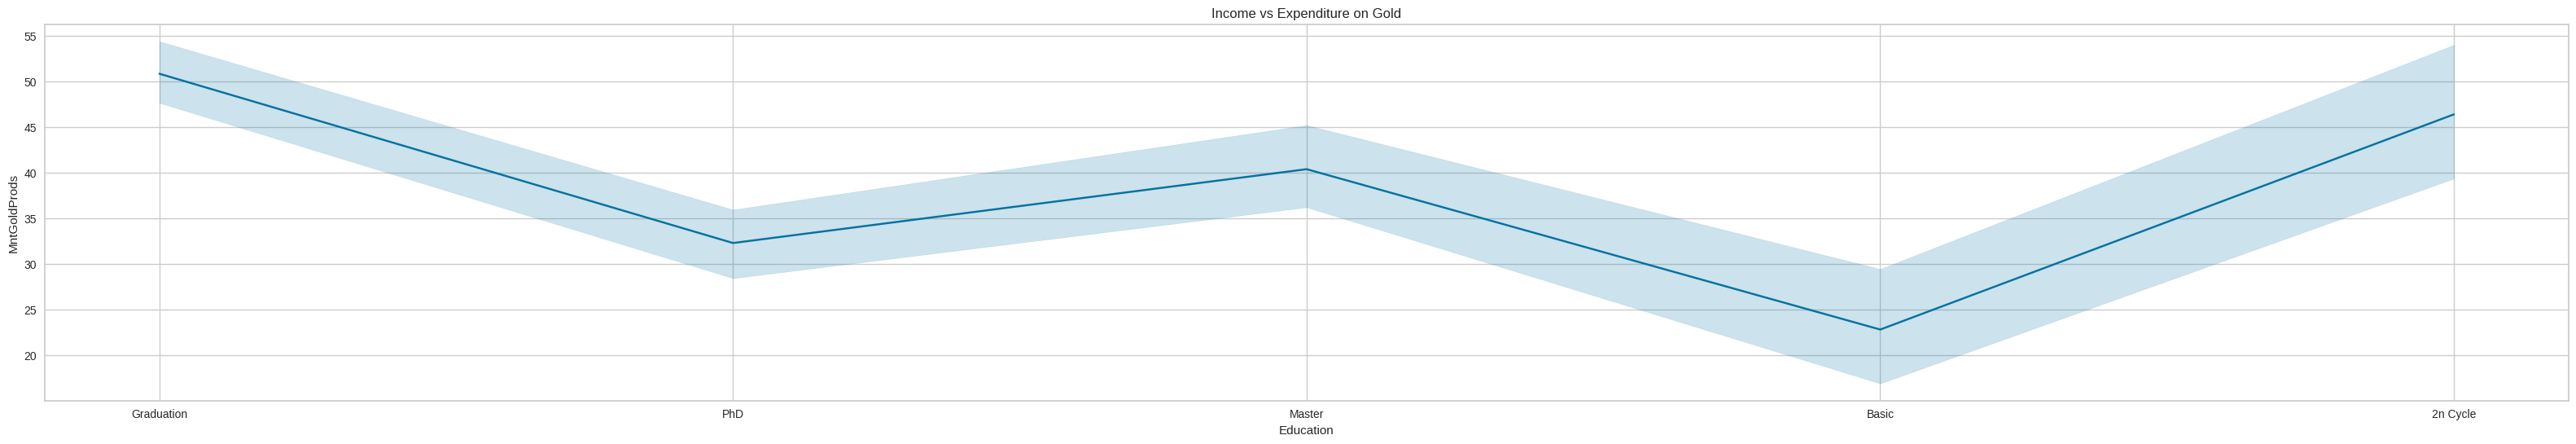

In [14]:
plt.figure(figsize=(40,6))
income_vs_gold = sns.lineplot(x="Education", y="MntGoldProds", data=df)
income_vs_gold.set(title="Income vs Expenditure on Gold")
income_vs_gold

# **KMeans Clustering**

KMeans Clustering process is that the features are divided into K clusters in a way that each observation is belongs to the cluster having the nearest mean, or centroid. An important consideration for applying any clustering algorithm is to determine the 'k' that will yield the most accurate results. This can be done in many ways; some of the popular methods include:


1.   The Elbow Method
2.   The Silhouette Method



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

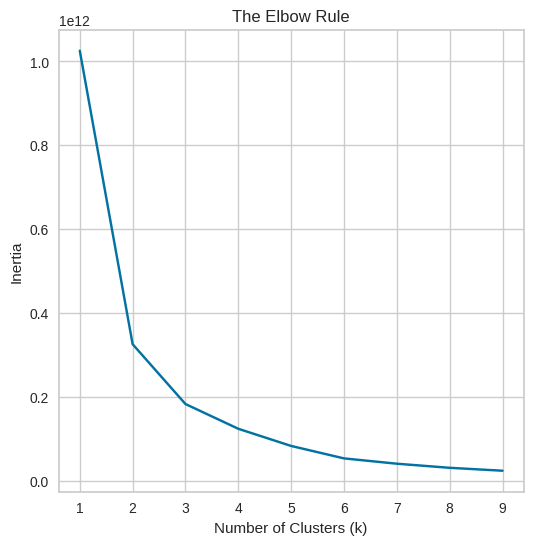

In [15]:
# Applying the Elbow method

inertias = []
possible_k_values = range(1,10)
features = ['Income', 'Total_Expenditure', 'Total_Purchases']

for k in possible_k_values:
   model = KMeans(k, random_state=20, init='k-means++').fit(clean_df[features])
   inertias.append(model.inertia_)


plt.figure(figsize=(6,6))    
plt.title("The Elbow Rule")
plt.plot(possible_k_values, inertias)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia');

No sharp elbow point obtained, as observed in the graph above. A cluster of 4 or 3 is suitable for analysis. Therefore, applying silhouette method to find out optimum clusters.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


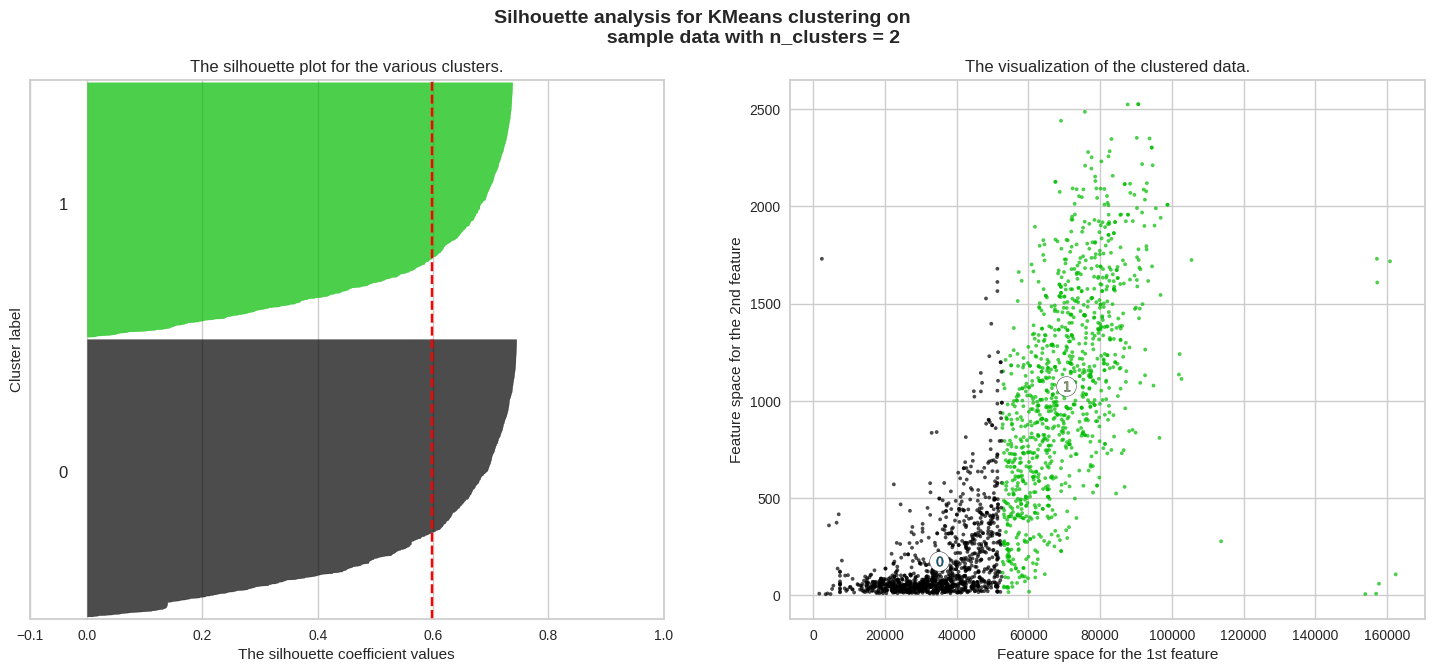

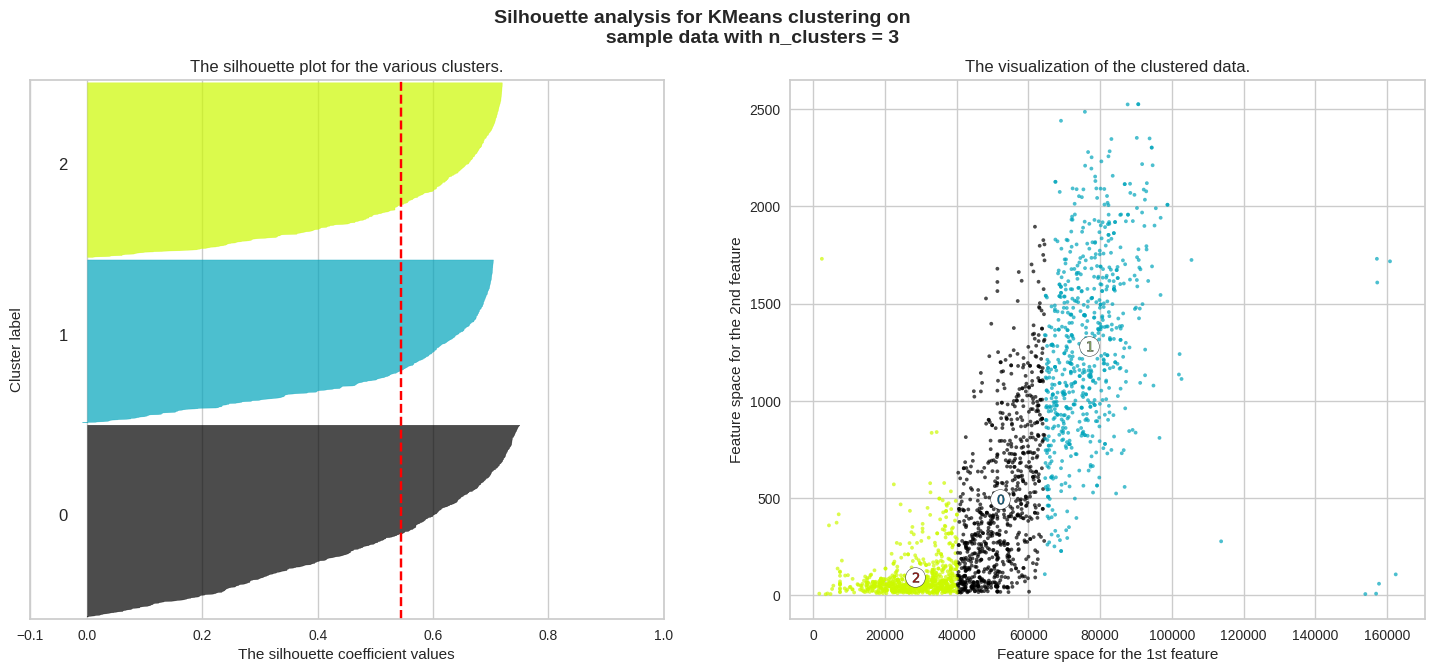

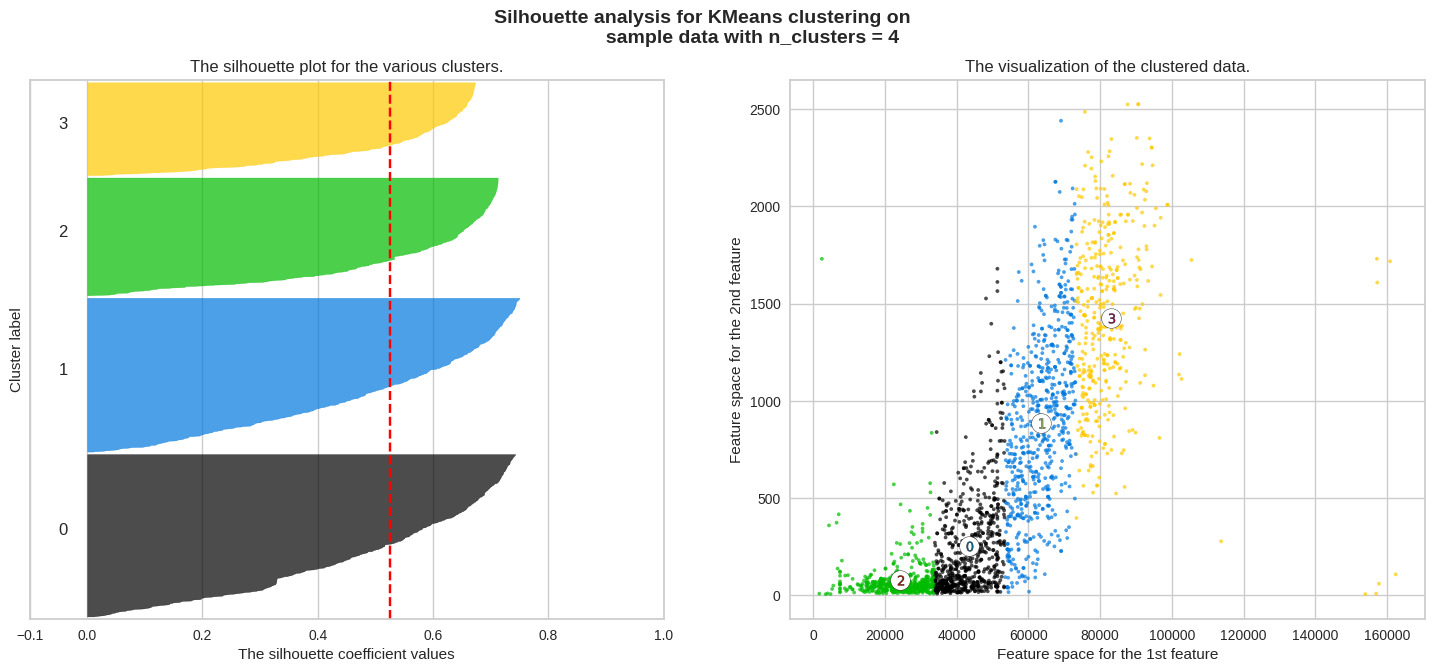

In [16]:
# Applying the Silhouette method

reduced_possible_k_values = range(2,5)

for k in reduced_possible_k_values:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(clean_df[features]) + (k + 1) * 10])

    model = KMeans(n_clusters=k, random_state=10)
    cluster_labels = model.fit_predict(clean_df[features])
    silhouette_avg = silhouette_score(clean_df[features], cluster_labels)
    sample_silhouette_values = silhouette_samples(clean_df[features], cluster_labels)

    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0,
                          ith_cluster_silhouette_values, facecolor=color,
                          edgecolor=color, alpha=0.7,)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(clean_df[features].iloc[:, 0], clean_df[features].iloc[:, 1], 
                marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

    centers = model.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker="o", c="white",
                alpha=1, s=200, edgecolor="k",)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle('''Silhouette analysis for KMeans clustering on 
                  sample data with n_clusters = %d'''
                  % k, fontsize=14, fontweight="bold",)

plt.show()

# **Analysis of Clustering Results**

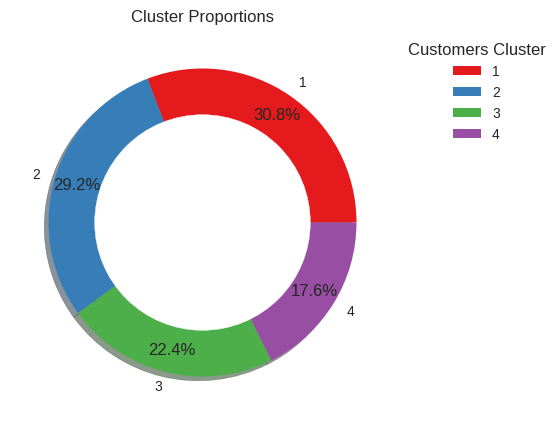

In [17]:
preds = model.predict(clean_df[features])
clusters = clean_df.copy()
clusters['Cluster'] = preds + 1

cluster_size = dict(clusters['Cluster'].value_counts())

plt.figure(figsize=(5, 5))
plt.title("Cluster Proportions")
plt.pie(cluster_size.values(), labels=sorted(cluster_size.keys()), 
        autopct="%.1f%%", pctdistance=0.85, shadow=True, 
        colors=sns.color_palette("Set1"))
plt.legend(title="Customers Cluster", labels=sorted(cluster_size.keys()), bbox_to_anchor=(1, 1))

donut = plt.Circle((0,0), 0.7, color='white')
p = plt.gcf()
p.gca().add_artist(donut)

plt.show()

Clusters 1 and 2 have a similar number of customers. However, Cluster 1 beats Cluster 2 marginally.

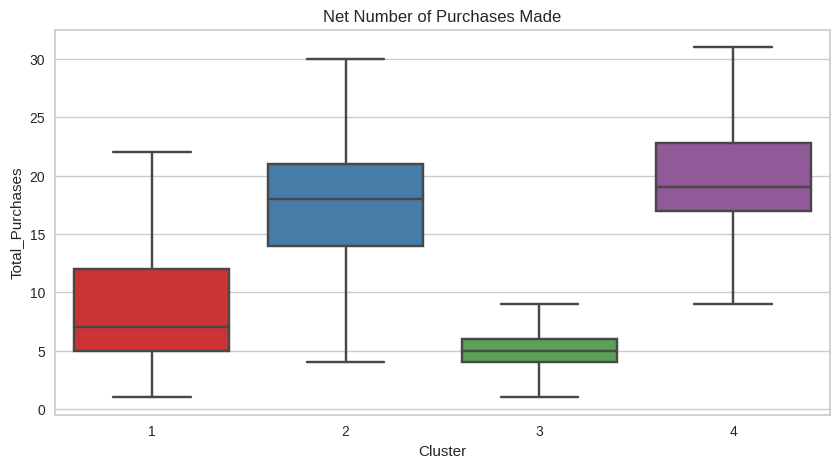

In [18]:
plt.figure(figsize=(10,5))
plt.title(f'Net Number of Purchases Made')
ax = sns.boxplot(data=clusters, x='Cluster', y='Total_Purchases', palette=sns.color_palette("Set1"), showfliers=False)
plt.show()

From the above box-whisker plots, following interpretations can be made:

1.  **Cluster 1**: Medium amount of purchases
2.  **Cluster 2:** High amount of purchases
3. **Cluster 3:** Low amount of purchases
4.  **Cluster 4:** Very High amount of purchases




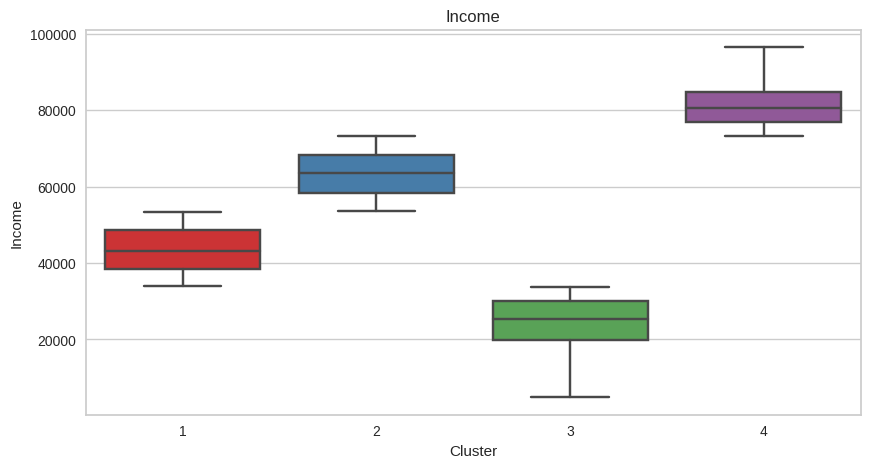

In [19]:
plt.figure(figsize=(10,5))
plt.title(f'Income')
axes = sns.boxplot(data=clusters, x='Cluster', y='Income', palette=sns.color_palette("Set1"), showfliers=False)
plt.show()

From the above box-whisker plots, following interpretations can be made:
1.   **Cluster 1:** Medium income
2.   **Cluster 2:** High Income
3.   **Cluster 3:** low income
4.   **Cluster 4:** Very high income

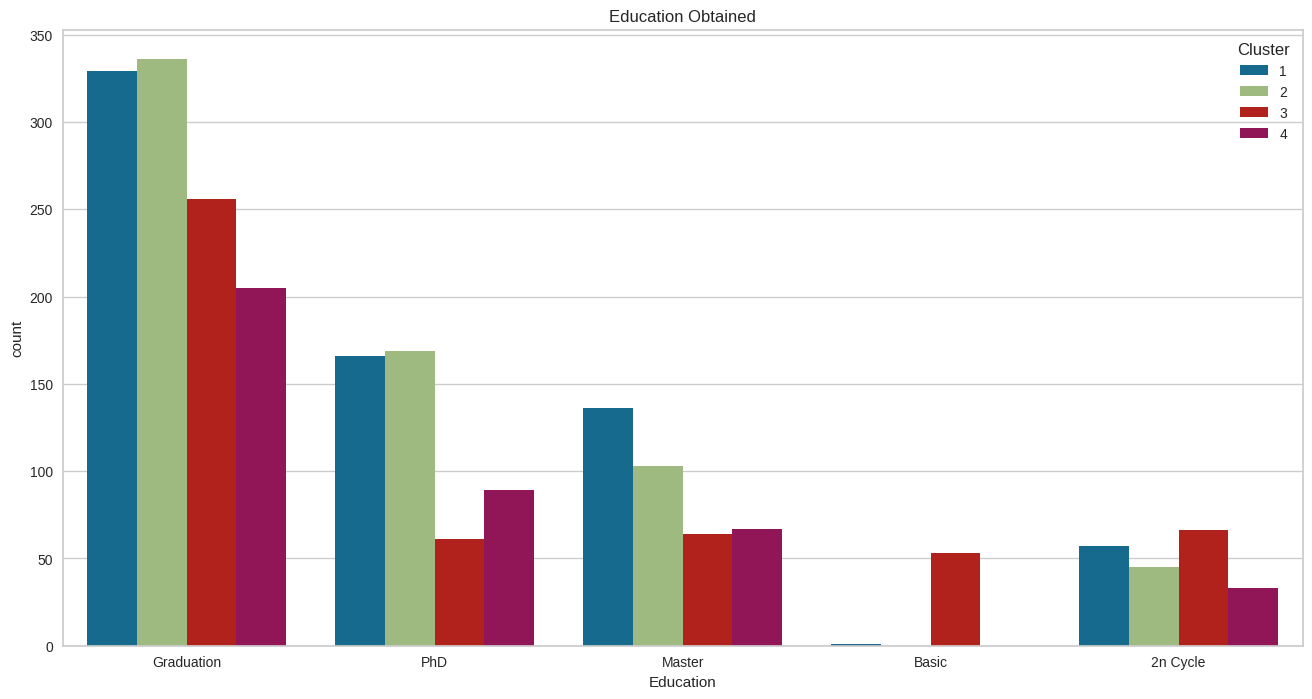

In [20]:
plt.figure(figsize=(16,8))
plt.title(f'Education Obtained')
sns.countplot(data=clusters, x='Education', hue='Cluster')
plt.show()

1.   **Graduation:** Cluster 4 
2.   **PhD Scholars:** Cluster 4
3.  **Masters Holders:** Cluster 1
4.  **Basic Education:** Cluster 3
5.  **2nd Cycle (European Masters):** Cluster 3

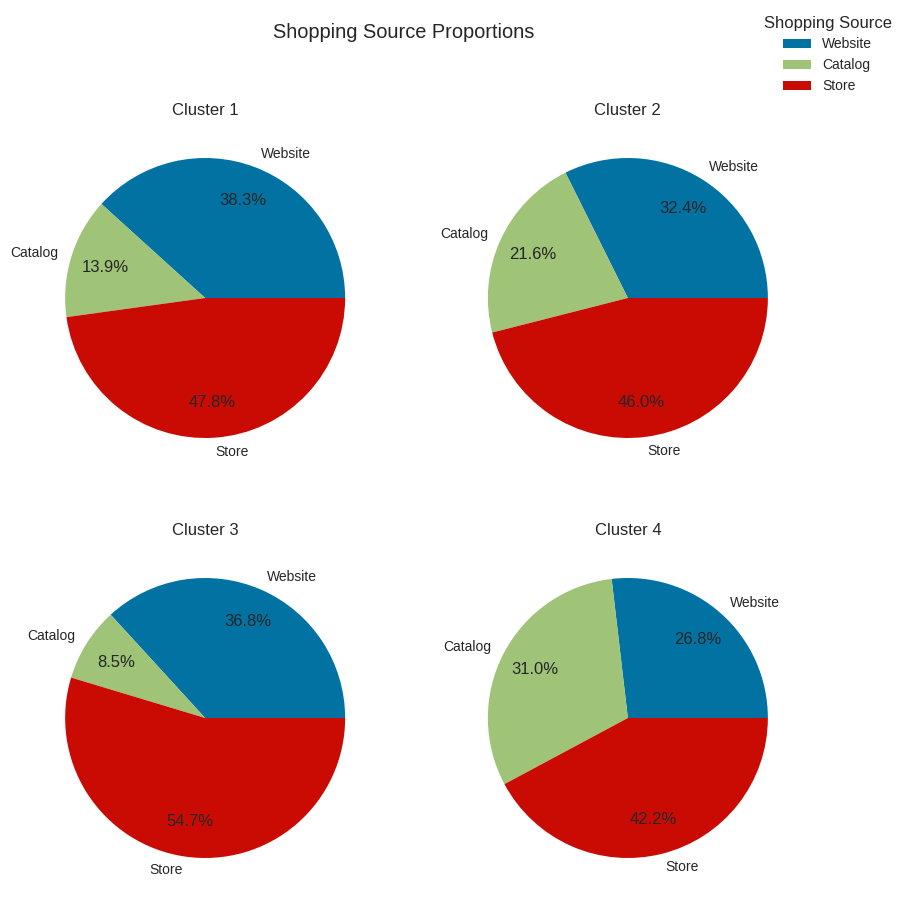

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))   
k = 0
for i in range(0, 2):
    for j in range(0, 2):
        k += 1
        num = clusters.query(f'Cluster == {k}').filter(regex='Num[^Deals|Total].+Purchases').sum(axis=0)
        sizes = dict(num)
        axes[i,j].set_title(f"Cluster {k}")
        axes[i,j].pie(sizes.values(), labels=['Website', 'Catalog', 'Store'], autopct="%.1f%%", pctdistance=0.75)

fig.suptitle('Shopping Source Proportions')
fig.legend(title="Shopping Source", labels=['Website', 'Catalog', 'Store'], bbox_to_anchor=(1,1)) 
fig.show()

All clusters make the maximum purchases at the store. Cluster 2 makes the maximum number of catalog purchases, one reason could possibly be because catalogs are often released during the sale period.

# **KMeans Customer Analysis**



1.   **Platinum Customers: Cluster 4** (Highly educated, very high income, mostly buy from the store)
2.   **Diamond Customers: Cluster 3** (Well educated, high income, mostly buy from the store) 
3.   **Gold Customers: Cluster 1** (Educated, medium income, highest website purchases)
4.   **Silver Customers: Cluster 2** (Comaparatively lesser education, low income, highest catalog purchases)



While online shopping and e-commerce are gaining popularity, customers continue to show a preference for purchasing items from offline stores. Nevertheless, the operation of a physical shop can be expensive due to various costs like rent, electricity, staffing, interiors, and maintenance. On the other hand, e-commerce provides a more cost-effective alternative. Hence, it is advisable for the company to focus on boosting its online presence and implementing promotional activities to incentivize customers to engage in online shopping.


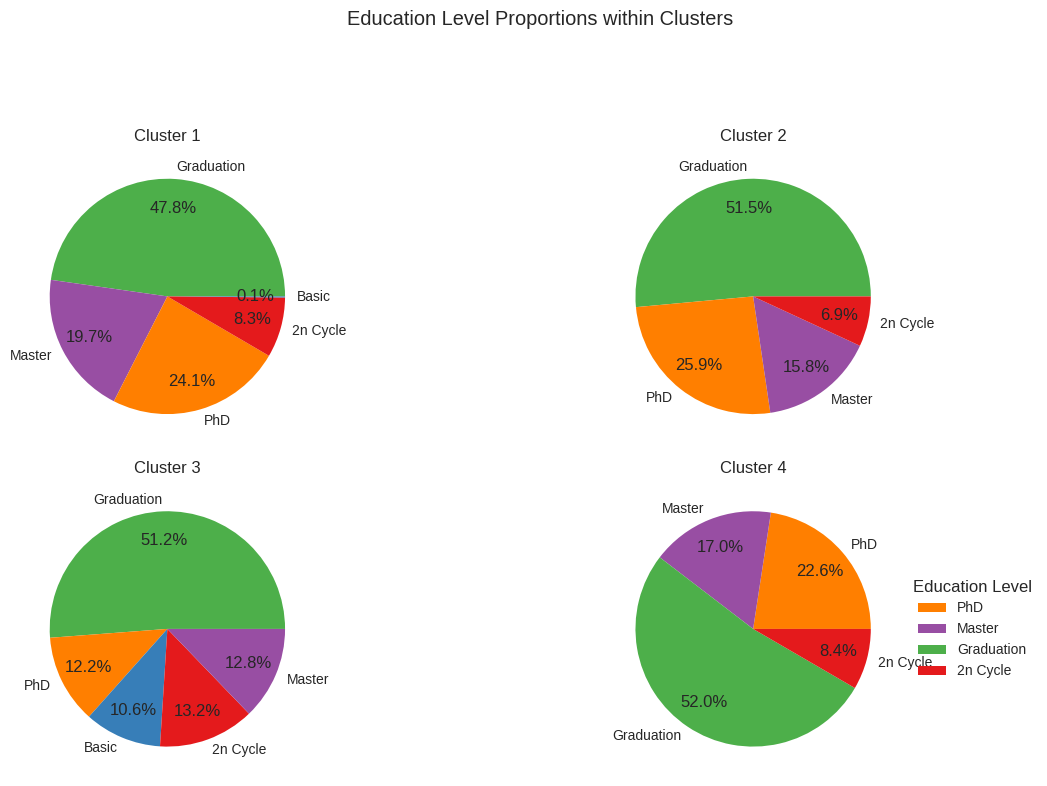

In [22]:
from collections import Counter

# Calculate cluster sizes
cluster_size = dict(clusters['Cluster'].value_counts())

# Define a color palette for education levels
education_levels = sorted(set(clusters['Education']))
education_palette = sns.color_palette("Set1", len(education_levels))
color_dict = dict(zip(education_levels, education_palette))

plt.figure(figsize=(16, 8))

# Iterate over each cluster
for cluster_num in sorted(cluster_size.keys()):
    cluster_data = clusters[clusters['Cluster'] == cluster_num]
    education_counts = dict(Counter(cluster_data['Education']))

    # Calculate proportions
    total = sum(education_counts.values())
    proportions = [count / total for count in education_counts.values()]

    # Plot the pie chart with consistent colors for each label
    ax = plt.subplot(2, 2, cluster_num)
    ax.set_title(f"Cluster {cluster_num}")
    wedges, labels, _ = ax.pie(proportions, labels=education_counts.keys(), autopct="%.1f%%",
                               pctdistance=0.75, colors=[color_dict[label] for label in education_counts.keys()])

# Create a single legend for the education levels
legend_labels = list(education_counts.keys())
plt.legend(wedges, legend_labels, title="Education Level", loc="center left", bbox_to_anchor=(1, 0.5))

plt.suptitle("Education Level Proportions within Clusters")
plt.tight_layout(rect=[0, 0, 0.9, 0.9])
plt.show()





**Analysis**: These results indicate the distribution of education levels within each cluster. It provides insights into the educational backgrounds of customers within different clusters. For example, in Cluster 1, the majority of customers have a Graduation education level, followed by Phd and Master degrees. In Cluster 2, Graduation is also the most common education level, while Cluster 3 shows a more diverse distribution across different education levels. Cluster 4 has a similar pattern to Cluster 1, with a higher proportion of customers with Graduation education.

In [23]:
sales_channel = df[['NumStorePurchases','NumWebPurchases','NumCatalogPurchases']]
sales_channel = pd.melt(sales_channel, value_vars=['NumStorePurchases','NumWebPurchases','NumCatalogPurchases'],
                        var_name='Channel',value_name='No_Transactions'
                        )

In [24]:
channel_grp = sales_channel.groupby('Channel')
sc_df = channel_grp[['No_Transactions']].sum()
sc_df

No_Transactions
Channel                             
NumCatalogPurchases             5963
NumStorePurchases              12970
NumWebPurchases                 9150

Text(0.5, 1.0, 'Most Used Sales Channel')

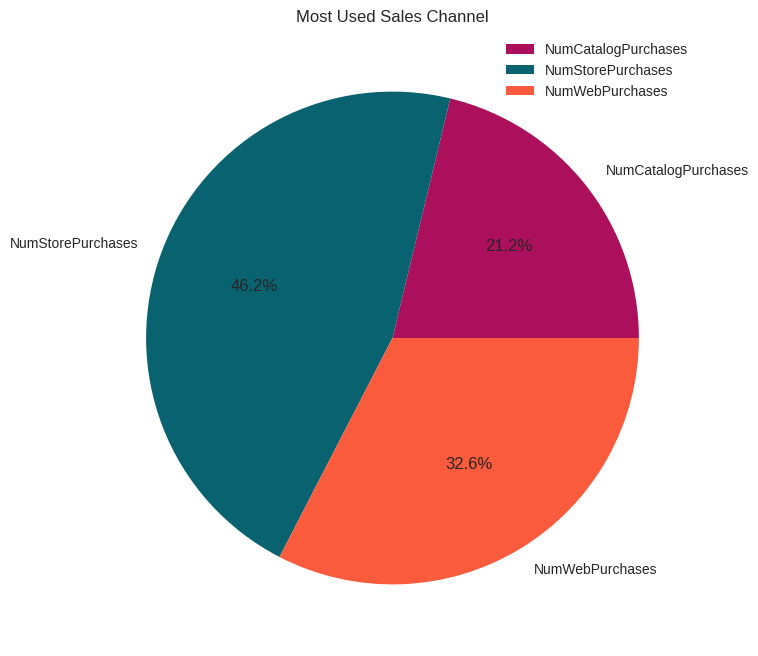

In [25]:
plt.figure(figsize=(16,8))
plt.pie(x=sc_df.No_Transactions,labels=sc_df.index,colors=['#ac0f5b','#09626f','#fa5b3d'],autopct='%1.1f%%')
plt.legend()
plt.title('Most Used Sales Channel')

Implementing XGboost Model

In [26]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from xgboost import plot_importance
import matplotlib.pyplot as plt
from numpy import sort
from sklearn.feature_selection import SelectFromModel

For ease, we will merge "Kid Home" and "Teen home" as one column i.e, "Child Home". Similarly, all campaigns will be combined into one column.

In [27]:
df['Childhome'] = df['Kidhome'] + df['Teenhome']
df['Total_Accepted_Cmp'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] \
                            + df['AcceptedCmp4'] + df['AcceptedCmp5']
train_df = df.drop(['Education', 'Marital_Status', 'Dt_Customer', 'Kidhome', 
                    'Teenhome', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
                   'AcceptedCmp4', 'AcceptedCmp5'], axis=1)
col_mask=train_df.isnull().any(axis=0) 
row_mask=train_df.isnull().any(axis=1)
#train_df.loc[row_mask,col_mask]
     



Filling missing values with median.

In [28]:
train_df[train_df == np.inf]=np.nan
train_df.fillna(train_df.median(), inplace=True)
#train_df.loc[row_mask,col_mask]

In [29]:
print(train_df['NumDealsPurchases'].value_counts())


1     970
2     497
3     297
4     189
5      94
6      61
0      46
7      40
8      14
9       8
15      7
10      5
11      5
12      4
13      3
Name: NumDealsPurchases, dtype: int64


In [30]:
X, y = train_df.loc[:, train_df.columns != 'NumDealsPurchases'], train_df['NumDealsPurchases']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

model = XGBClassifier(learning_rate = 0.05, n_estimators=300, max_depth=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

ValueError: ignored

In [31]:

X, y = train_df.loc[:, train_df.columns != 'Total_Accepted_Cmp'], train_df['Total_Accepted_Cmp']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

model = XGBClassifier(learning_rate = 0.05, n_estimators=300, max_depth=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
     

Accuracy: 83.93%


Optimum accuracy acore

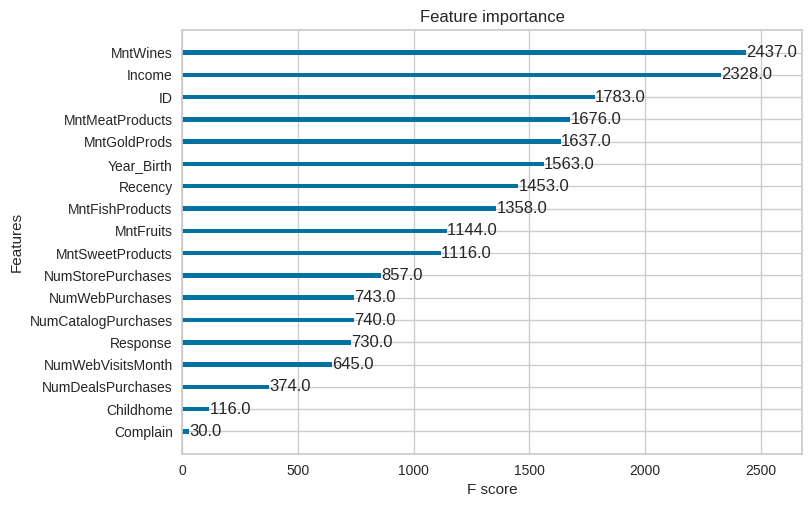

In [32]:
plot_importance(model)
plt.show()

From above graph, Wine and Income are two important determinants for accepting campaigns.

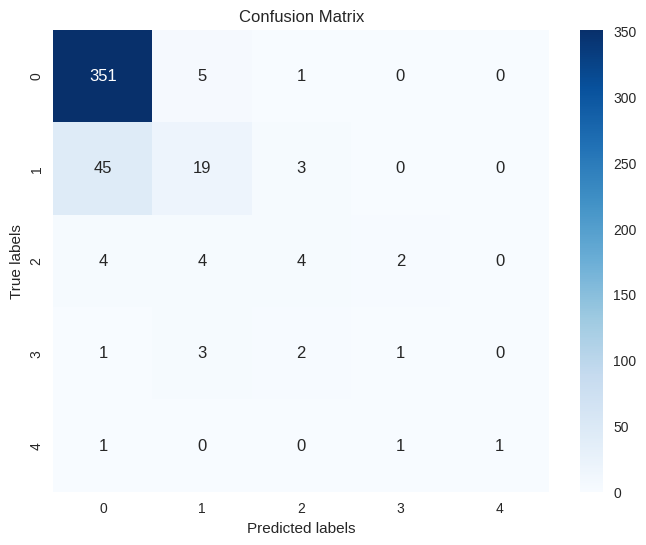

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier

# Split the dataset into features (X) and target (y)
X = train_df.loc[:, train_df.columns != 'Total_Accepted_Cmp']
y = train_df['Total_Accepted_Cmp']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Create and train the XGBoost classifier model
model = XGBClassifier(learning_rate=0.05, n_estimators=300, max_depth=5)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Create confusion matrix
labels = np.unique(y)
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Customize plot labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


In [38]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")



Accuracy: 0.8392857142857143
Precision: 0.627207510832932
Recall: 0.40573602575358503
F1-Score: 0.46556156059261655


Accuracy: 0.8392857142857143

The accuracy score represents the proportion of correctly predicted labels (both true positives and true negatives) out of the total number of instances in the testing set. In your case, the model achieved an accuracy of approximately 83.93%, indicating that it made accurate predictions for the majority of the instances.
Precision: 0.627207510832932

Precision measures the proportion of true positive predictions out of the total instances predicted as positive. It indicates how well the model identifies positive instances correctly. In your case, the precision score is around 62.72%, suggesting that the model has a moderate ability to correctly classify positive instances.
Recall: 0.40573602575358503

Recall (also known as sensitivity or true positive rate) measures the proportion of true positive predictions out of the total actual positive instances. It indicates the model's ability to capture positive instances. In your case, the recall score is approximately 40.57%, indicating that the model identifies only about 40.57% of the actual positive instances.
F1-Score: 0.46556156059261655

The F1-score is the harmonic mean of precision and recall. It provides a balanced measure of the model's performance, considering both precision and recall. In your case, the F1-score is approximately 46.56%, suggesting a moderate balance between precision and recall.

In [41]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.93%


In [43]:
from sklearn.metrics import f1_score

X, y = train_df.loc[:, train_df.columns != 'Total_Accepted_Cmp'], train_df['Total_Accepted_Cmp']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

model = XGBClassifier(learning_rate=0.05, n_estimators=300, max_depth=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

f1 = f1_score(y_test, y_pred, average='macro')
print("F1 Score: %.2f" % f1)


F1 Score: 0.47


In [45]:
from sklearn.metrics import confusion_matrix

# Assuming you have the true labels (y_test) and predicted labels (y_pred)
cm = confusion_matrix(y_test, y_pred)

# Extract true positives, false positives, and false negatives from the confusion matrix
TP = cm[1, 1]
FP = cm[0, 1]
FN = cm[1, 0]

# Calculate precision and recall
precision = TP / (TP + FP)
recall = TP / (TP + FN)

print("Precision:", precision)
print("Recall:", recall)


Precision: 0.7916666666666666
Recall: 0.296875


In [34]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Fit the XGBoost regression model
model = XGBRegressor(learning_rate=0.05, n_estimators=300, max_depth=5)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate root mean squared error (RMSE)
rmse = np.sqrt(mse)

print("Root Mean Squared Error (RMSE): %.2f" % rmse)


Root Mean Squared Error (RMSE): 0.44


In [46]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

#function
def train_test_rmse(x,y):
    x = Iris_data[x]
    y = Iris_data[y]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2,random_state=123)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    print(accuracy_score(y_test, y_pred))  # or you can save it in variable and return it 
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [36]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Fit the XGBoost regression model
model = XGBRegressor(learning_rate=0.05, n_estimators=300, max_depth=5)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate root mean squared error (RMSE)
rmse = np.sqrt(mse)

print("Root Mean Squared Error (RMSE): %.2f" % rmse)


Root Mean Squared Error (RMSE): 0.44


In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Obtain predicted labels
y_pred = model.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate precision, recall, and F-score
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
f_score = 2 * (precision * recall) / (precision + recall)

print("Precision: %.2f" % precision)
print("Recall: %.2f" % recall)
print("F-score: %.2f" % f_score)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


ValueError: ignored

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Obtain predicted labels
y_pred = model.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


ValueError: ignored

In [41]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.93%


In [ ]:

thresholds = sort(model.feature_importances_)
for threshold in thresholds:
    selection = SelectFromModel(model, threshold=threshold, prefit=True)
    select_X_train = selection.transform(X_train)
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (threshold, select_X_train.shape[1], accuracy*100.0))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=21, Accuracy: 84.82%


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=21, Accuracy: 84.82%


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=21, Accuracy: 84.82%


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.017, n=18, Accuracy: 84.82%


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.040, n=17, Accuracy: 83.93%


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.041, n=16, Accuracy: 82.59%


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.041, n=15, Accuracy: 84.38%


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.043, n=14, Accuracy: 83.48%


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.044, n=13, Accuracy: 83.71%


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.049, n=12, Accuracy: 83.26%


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.050, n=11, Accuracy: 83.26%


Number of features and comparing their accuracies: Decreasing